In [1]:
from gym_trading_env.downloader import download
from gym_trading_env.renderer import Renderer
import datetime
import pandas as pd
import glob
import numpy as np
import gymnasium as gym
import gym_trading_env
import torch
import MultiTrade

import matplotlib.pyplot as plt
from ray import train, tune

In [2]:
from Pearl.pearl.pearl_agent import PearlAgent
from Pearl.pearl.utils.instantiations.environments.gym_environment import GymEnvironment
from Pearl.pearl.neural_networks.sequential_decision_making.q_value_networks import VanillaQValueNetwork,QValueNetwork
from Pearl.pearl.neural_networks.sequential_decision_making.actor_networks import VanillaContinuousActorNetwork,GaussianActorNetwork
from Pearl.pearl.policy_learners.exploration_modules.common.normal_distribution_exploration import NormalDistributionExploration
from Pearl.pearl.utils.functional_utils.experimentation.set_seed import set_seed
from Pearl.pearl.policy_learners.sequential_decision_making.deep_q_learning import DeepQLearning
from Pearl.pearl.policy_learners.sequential_decision_making.double_dqn import DoubleDQN
from Pearl.pearl.replay_buffers.sequential_decision_making.fifo_off_policy_replay_buffer import FIFOOffPolicyReplayBuffer
from Pearl.pearl.utils.functional_utils.train_and_eval.online_learning import online_learning
from Pearl.pearl.action_representation_modules.one_hot_action_representation_module import OneHotActionTensorRepresentationModule

from Pearl.pearl.policy_learners.sequential_decision_making.td3 import TD3
from Pearl.pearl.user_envs.wrappers.gym_avg_torque_cost import GymAvgTorqueWrapper
from Pearl.pearl.safety_modules.reward_constrained_safety_module import RCSafetyModuleCostCriticContinuousAction

In [3]:
COIN_PAIRS=['BTC/USDT','ETH/USDT','SOL/USDT','BNB/USDT','XRP/USDT','ADA/USDT']
time_frame="1h"

In [4]:

# download(exchange_names = ["binance"],
#     symbols= COIN_PAIRS,
#     timeframe= time_frame,
#     dir = "data",
#     since= datetime.datetime(year= 2024, month= 1, day=1),
# )

In [5]:

files=glob.glob(f'data/**{time_frame}.pkl',)

# dates=[]
# returns=[2,5,10,15,20,25,30]
# for file in files:
#     data=pd.read_pickle(file)
#     for r in returns:
#         data[f'feature_log_return_{r}'] = np.log(1 + data.close.pct_change(r)+1e-15)
#         data[f'feature_log_volume_{r}'] = np.log(1 + data.volume.pct_change(r)+1e-15)
#         data = data.replace((np.inf, -np.inf,np.nan), 0)
#         data[f'feature_log_return_{r}']=data[f'feature_log_return_{r}'].values/np.linalg.norm(data[f'feature_log_return_{r}'].values)#.rolling(window=96).apply(compute_z)
#         data[f'feature_log_volume_{r}']=data[f'feature_log_volume_{r}'].values/np.linalg.norm(data[f'feature_log_volume_{r}'].values)#.rolling(window=96).apply(compute_z)
#     dates.append(data.reset_index()[['date_open']].rename(columns={'date_open':file.split('-')[1]}))
#     data = data.replace((np.inf, -np.inf), np.nan)
#     data=data.to_pickle(dec)

In [6]:
train_envs={}
test_envs={}
start_date=datetime.datetime(year= 2024, month= 2, day=1)
split_date=start_date+datetime.timedelta(days=7)
end_date=split_date+datetime.timedelta(days=7)
## make a dict of training env the big multi env will live ontop of
for file in files:
    data=pd.read_pickle(file)
    name=file.split('-')[1]
    train_data=data[start_date:split_date]
    train_envs[name] = gym.make("BoxTradingEnv",
            name=name,
            df = train_data, # Your dataset with your custom features
            positions = [ -.25, 0, .25], # -1 (=SHORT), 0(=OUT), +1 (=LONG)
            trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
            borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
        )
    
    test_data=data[split_date:end_date]
    test_envs[name] = gym.make("BoxTradingEnv",
            name=name,
            df = test_data, # Your dataset with your custom features
            positions = [ -.25, 0, .25], # -1 (=SHORT), 0(=OUT), +1 (=LONG)
            trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
            borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)

        )

In [7]:
train_env=train_envs['BTCUSDT']

In [8]:
train_env.action_space

Box(-0.25, 0.25, (1,), float32)

In [9]:
train_env=GymEnvironment(train_env)
num_actions = train_env.action_space
hidden_dims = [64, 64]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [10]:
obs=train_env.reset()
# env.action_space.sa
for i in range(20):
    act=train_env.action_space.sample()
    act_result=train_env.step(act)
act_result.info['portfolio_valuation']/1000

0.9967894196265091

In [11]:
def _list_value(x):
    return[x,x]

search_space={
            "actor_hidden_dims" : _list_value(tune.grid_search([64,128,256])),

            'critic_hidden_dims' : _list_value(tune.grid_search([64,128,256])),

            'training_rounds' : tune.choice([1, 2, 3]),

            'batch_size':  tune.choice([64,128,256]),

            'actor_soft_update_tau': tune.uniform(0.0001, 0.05),

            'critic_soft_update_tau': tune.uniform(0.0001, 0.05),

            'actor_learning_rate': tune.uniform(1e-6, 1e-3),

            'critic_learning_rate': tune.uniform(1e-6, 1e-3),
            
            'discount_factor': tune.uniform(1e-6, 1),

            'actor_update_freq': tune.choice([c for c in range(2,60,2)]),

            'actor_update_noise':tune.uniform(1e-6, 1),

            'actor_update_noise_clip':tune.uniform(1e-6, 1),

            'exploration_module':{
                                    'mean':tune.uniform(1e-6,.5),
                                    'std_dev':tune.uniform(1e-6, .5),
                                    },
            'RC_module':{
                        'critic_hidden_dims':_list_value(tune.grid_search([64,128,256])),
                        'constraint_value':tune.choice([.2,.4,.6]),
                        'lambda_constraint_ub_value':tune.choice([c for c in range(100,200,2)]),
                        'lr_lambda':tune.uniform(1e-6, 1e-3),

                                    },
            }

In [12]:
def objective(config):

    train_env=train_envs['BTCUSDT']
    test_env=test_envs['BTCUSDT']

    exploration_args=config.pop('exploration_module')
    RC_args=config.pop('RC_module')

    rctd3_agent = PearlAgent(
                    policy_learner=TD3(
                        
                        state_dim=train_env.observation_space.shape[0],
                        action_space=train_env.action_space,
                        exploration_module=NormalDistributionExploration(exploration_args),
                        **config
                    ),
                    replay_buffer=FIFOOffPolicyReplayBuffer(
                        capacity=100000,
                        has_cost_available=True
                    ),
                    safety_module=RCSafetyModuleCostCriticContinuousAction(
                        state_dim=train_env.observation_space.shape[0],
                        action_space=train_env.action_space,
                        **RC_args
                    ),
                )
    
    info = online_learning(
        agent=rctd3_agent ,
        env=train_env,
        number_of_episodes=2_000,
        print_every_x_episodes=10,   # print returns after every 10 episdoes
        learn_after_episode=False,    # updating after every environment interaction, Q networks are updates at the end of each episode
        seed=0
    )
    agent=rctd3_agent
    observation, action_space = test_env.reset()
    agent.reset(observation, action_space)
    done = False
    while not done:
        action = agent.act(exploit=True)
        action_result = test_env.step(action)
        agent.observe(action_result)
        agent.learn()
        done = action_result.done
        
    score=act_result.info['portfolio_valuation']/1000

    return {"score": -score}

In [13]:
train_env=train_envs['BTCUSDT']
train_env=GymEnvironment(train_env)

test_env=test_envs['BTCUSDT']
test_env=GymEnvironment(test_env)
train_env.action_space
set_seed(0)


In [14]:
# setup TD3 algorithm
td3_agent = PearlAgent(
                        policy_learner=TD3(
                                                state_dim=train_env.observation_space.shape[0],
                                                action_space=train_env.action_space,
                                                actor_hidden_dims= [256, 256],
                                                critic_hidden_dims= [256, 256],
                                                training_rounds= 10,
                                                batch_size= 256,

                                                actor_soft_update_tau= 0.5,
                                                critic_soft_update_tau= 0.5,
                                                actor_learning_rate= 1e-3,
                                                critic_learning_rate= 3e-4,
                                                discount_factor= 0.99,
                                                actor_update_freq= 2,
                                                actor_update_noise= 0.2,
                                                actor_update_noise_clip= 0.5,

                                                exploration_module=NormalDistributionExploration(
                                                                                                    mean=0.0,
                                                                                                    std_dev=0.1,
                                                                                                    ),
                                                                                                    
                                            ),
                        replay_buffer=FIFOOffPolicyReplayBuffer(
                            capacity=100000,
                            has_cost_available=False
                        ),
                        safety_module=None,
                        device_id=-1,

                    )


Market Return :  5.18%   |   Portfolio Return : -1.30%   |   
Market Return :  5.18%   |   Portfolio Return : -1.30%   |   
Market Return :  5.18%   |   Portfolio Return : -1.30%   |   
Market Return :  5.18%   |   Portfolio Return : -1.30%   |   
Market Return :  5.18%   |   Portfolio Return : -1.30%   |   
Market Return :  5.18%   |   Portfolio Return : -1.30%   |   
Market Return :  5.18%   |   Portfolio Return : -1.30%   |   
Market Return :  5.18%   |   Portfolio Return : -1.30%   |   
Market Return :  5.18%   |   Portfolio Return : -1.30%   |   
Market Return :  5.18%   |   Portfolio Return : -1.30%   |   
episode 10, step 1680, agent=PearlAgent with TD3, FIFOOffPolicyReplayBuffer, env=BoxTradingEnv
return: -0.013090495130199997
Market Return :  5.18%   |   Portfolio Return : -1.30%   |   
Market Return :  5.18%   |   Portfolio Return : -1.30%   |   
Market Return :  5.18%   |   Portfolio Return : -1.30%   |   
Market Return :  5.18%   |   Portfolio Return : -1.30%   |   
Market 

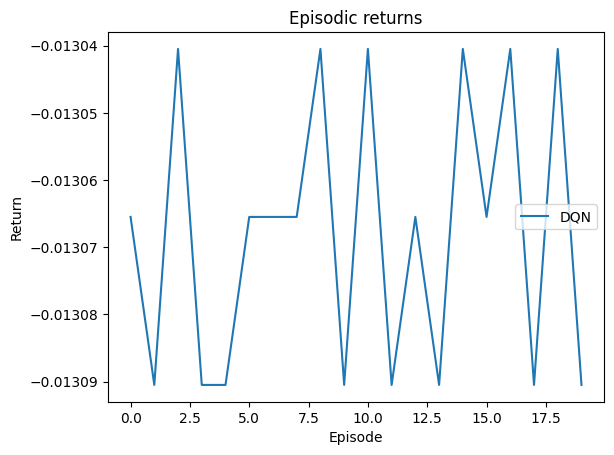

In [16]:
info = online_learning(
    agent=td3_agent ,
    env=train_env,
    number_of_episodes=2_0,
    print_every_x_episodes=10,   # print returns after every 10 episdoes
    learn_after_episode=False,    # updating after every environment interaction, Q networks are updates at the end of each episode
    seed=0

)

torch.save(info["return"], "DQN-return.pt")   # info["return"] refers to the episodic returns
plt.plot(np.arange(len(info["return"])), info["return"], label="DQN")
plt.title("Episodic returns")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.legend()
plt.show()

In [17]:
def trial_str_creator(trial):
    return "{}_{}_123".format(trial.trainable_name, trial.trial_id)

tune_config=tune.TuneConfig(num_samples=13,mode="min",search_alg='hyperopt',
                                trial_name_creator=trial_str_creator,
                                trial_dirname_creator=trial_str_creator,
                            )
run_config=train.RunConfig(
    storage_path='C:/Users/standard/OneDrive/Documents/Git/MultiTrader/td3_results', 

    name="pearl_experiments")

tuner = tune.Tuner(objective,
                   tune_config=tune_config,
                   run_config=run_config,
                    param_space=search_space)  # ③


results = tuner.fit()
print(results.get_best_result(metric="score", mode="min").config)

2024-03-28 13:42:35,272	WARNING trial.py:648 -- The path to the trial log directory is too long (max length: 260. Consider using `trial_dirname_creator` to shorten the path. Path: C:\Users\standard\AppData\Local\Temp\ray\session_2024-03-28_13-42-20_595797_7364\artifacts\2024-03-28_13-42-24\objective_2024-03-28_13-42-20\driver_artifacts\objective_89675_00000_0_constraint_value=0.2000,0=64,1=64,lambda_constraint_ub_value=156,lr_lambda=0.0001,0=64,1=64,actor_learning_2024-03-28_13-42-35


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:\\Users\\standard\\AppData\\Local\\Temp\\ray\\session_2024-03-28_13-42-20_595797_7364\\artifacts\\2024-03-28_13-42-24\\objective_2024-03-28_13-42-20\\driver_artifacts\\objective_89675_00000_0_constraint_value=0.2000,0=64,1=64,lambda_constraint_ub_value=156,lr_lambda=0.0001,0=64,1=64,actor_learning_2024-03-28_13-42-35'

In [ ]:
test_env.env.unwrapped.save_for_render(dir = "TD3_test_render_logs")

In [ ]:

renderer = Renderer(render_logs_dir="render_logs")

In [ ]:
# Add Custom Metrics (Annualized metrics)
renderer.add_metric(
    name = "Annual Market Return",
    function = lambda df : f"{ ((df['close'].iloc[-1] / df['close'].iloc[0])**(pd.Timedelta(days=365)/(df.index.values[-1] - df.index.values[0]))-1)*100:0.2f}%"
)
renderer.add_metric(
        name = "Annual Portfolio Return",
        function = lambda df : f"{((df['portfolio_valuation'].iloc[-1] / df['portfolio_valuation'].iloc[0])**(pd.Timedelta(days=365)/(df.index.values[-1] - df.index.values[0]))-1)*100:0.2f}%"
)

renderer.run()